In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import mean_squared_error

/Users/afsinozdemir/anaconda3/envs/NewAtlantisPro/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Monthly chlorophyll data

In [3]:
df_cho = pd.read_csv('../data/monthly_data/monthly_chlor_a.csv')
df_cho = df_cho.drop(columns='Unnamed: 0')
df_cho

,year,month,lon_rounded_up,lat_rounded_up,chlor_a
0,2004,4,-95,-10,0.137858
1,2004,4,-95,-5,0.174164
2,2004,4,-95,0,0.231936
3,2004,4,-95,5,0.211113
4,2004,4,-95,10,0.149035
...,...,...,...,...,...
47995,2024,3,0,15,NaN
47996,2024,3,0,20,NaN
47997,2024,3,0,25,NaN
47998,2024,3,0,30,NaN


In [4]:
df_cho.rename(columns={'lon_rounded_up':'lon', 'lat_rounded_up':'lat'}, inplace=True)
df_monthly_cho = df_cho.copy()

In [4]:
# df_cho['date'] = df_cho[['year','month']].astype(str).agg("-".join, axis=1)
# df_cho.drop(columns=['year','month'], inplace=True)
# df_cho['date'] = pd.to_datetime(df_cho['date'])

In [5]:
df_monthly_cho.drop(columns='year', inplace=True)
df_monthly_cho.groupby(['lon','lat','month'], as_index=False).mean()

,lon,lat,month,chlor_a
0,-95,-10,1,0.126944
1,-95,-10,2,0.123157
2,-95,-10,3,0.122621
3,-95,-10,4,0.125460
4,-95,-10,5,0.123218
...,...,...,...,...
2395,0,35,8,NaN
2396,0,35,9,13.667533
2397,0,35,10,13.670171
2398,0,35,11,10.447283


In [6]:
df_monthly_cho['lon'] = df_monthly_cho['lon'].apply(lambda x: x - 5)
df_monthly_cho['lat'] = df_monthly_cho['lat'].apply(lambda x: x - 5)

# Depth Data

In [7]:
df_depth = pd.read_csv('../data/Depth_Data.csv')
df_depth.drop(columns='Unnamed: 0', inplace=True)
df_depth.rename(columns={'Latitude':'lat','Longitude':'lon'},inplace=True)
months = pd.DataFrame({'month': range(1, 13)})
df_depth_expanded = df_depth.merge(months, how='cross')
df_depth_expanded

,lat,lon,Elevation,month
0,-15.0,-100.0,-3877.0,1
1,-15.0,-100.0,-3877.0,2
2,-15.0,-100.0,-3877.0,3
3,-15.0,-100.0,-3877.0,4
4,-15.0,-100.0,-3877.0,5
...,...,...,...,...
2395,30.0,-5.0,1041.0,8
2396,30.0,-5.0,1041.0,9
2397,30.0,-5.0,1041.0,10
2398,30.0,-5.0,1041.0,11


# Sea Surface Temparature (SST)

In [10]:
df_sst = pd.read_csv('../data/monthly_data/sst_data.csv')
df_sst['date'] = pd.to_datetime(df_sst['date'])
df_sst['month'] = df_sst['date'].dt.month
df_sst.drop(columns='date', inplace=True)
df_sst

,lat,lon,sst,month
0,34.5,-99.5,NaN,8
1,34.5,-99.5,NaN,9
2,34.5,-99.5,NaN,10
3,34.5,-99.5,NaN,11
4,34.5,-99.5,NaN,12
...,...,...,...,...
47995,-10.5,-4.5,28.149033,3
47996,-10.5,-4.5,28.991533,4
47997,-10.5,-4.5,29.049034,5
47998,-10.5,-4.5,29.089033,6


In [11]:
df_sst['lat'] = df_sst['lat'].apply(lambda x: x-4.5)
df_sst['lon'] = df_sst['lon'].apply(lambda x: x-0.5)

In [12]:
df_sst = df_sst.groupby(['lon','lat','month'], as_index=False).mean()

In [13]:
df_sst

,lon,lat,month,sst
0,-100.0,-15.0,1,28.601102
1,-100.0,-15.0,2,28.640102
2,-100.0,-15.0,3,28.852597
3,-100.0,-15.0,4,28.883831
4,-100.0,-15.0,5,28.856734
...,...,...,...,...
2395,-5.0,30.0,8,28.386001
2396,-5.0,30.0,9,28.277601
2397,-5.0,30.0,10,28.274236
2398,-5.0,30.0,11,28.607119


## Salinity

In [20]:
df_salinity = pd.read_csv('../data/monthly_data/Mean_Temp_Salinity_Oxygen.csv')
df_salinity.drop(columns='Unnamed: 0', inplace=True)

df_salinity = df_salinity[['lat', 'long', 'month','year','s']]

df_salinity.rename(columns={'long':'lon'}, inplace=True)

df_salinity.drop(columns='year',inplace=True)

df_salinity = df_salinity.groupby(['lat','lon','month'], as_index=False).mean()
df_salinity.rename(columns={'s':'salinity'},inplace=True)

In [21]:
df_salinity

,lat,lon,month,salinity
0,-15.0,-100.0,1,35.133911
1,-15.0,-100.0,2,35.099804
2,-15.0,-100.0,3,35.126385
3,-15.0,-100.0,4,35.130784
4,-15.0,-100.0,5,35.136304
...,...,...,...,...
1484,30.0,-10.0,6,36.318945
1485,30.0,-10.0,7,36.133174
1486,30.0,-10.0,9,36.142374
1487,30.0,-10.0,10,36.133018


## Test Oxygen

In [23]:
df_test_o = pd.read_csv('../data/monthly_data/Mean_Temp_Salinity_Oxygen.csv')
df_test_o.drop(columns='Unnamed: 0', inplace=True)
df_test_o = df_test_o[['lat', 'long', 'month','year','oxygen']]
df_test_o.rename(columns={'long':'lon'}, inplace=True)
df_test_o = df_test_o.groupby(['lat','lon','month'], as_index=False).mean()
df_test_o.rename(columns={'oxygen':'dissolved_oxygen'}, inplace=True)
df_test_o.drop(columns='year', inplace=True)
df_test_o

,lat,lon,month,dissolved_oxygen
0,-15.0,-100.0,1,113.316178
1,-15.0,-100.0,2,93.838839
2,-15.0,-100.0,3,91.788972
3,-15.0,-100.0,4,103.631464
4,-15.0,-100.0,5,103.154461
...,...,...,...,...
1484,30.0,-10.0,6,219.745598
1485,30.0,-10.0,7,217.869142
1486,30.0,-10.0,9,214.324262
1487,30.0,-10.0,10,211.179807


## Temparature

In [24]:
df_temp = pd.read_csv('../data/monthly_data/Mean_Temp_Salinity_Oxygen.csv')
df_temp.drop(columns='Unnamed: 0', inplace=True)
df_temp = df_temp[['lat', 'long', 'month','year','t']]
df_temp.rename(columns={'long':'lon'}, inplace=True)
df_temp.drop(columns='year',inplace=True)
df_temp = df_temp.groupby(['lat','lon','month'], as_index=False).mean()
df_temp.rename(columns={'t':'Temp'},inplace=True)
df_temp

,lat,lon,month,Temp
0,-15.0,-100.0,1,15.993631
1,-15.0,-100.0,2,15.916061
2,-15.0,-100.0,3,16.278789
3,-15.0,-100.0,4,16.650392
4,-15.0,-100.0,5,16.670980
...,...,...,...,...
1484,30.0,-10.0,6,17.185778
1485,30.0,-10.0,7,15.840264
1486,30.0,-10.0,9,16.615128
1487,30.0,-10.0,10,16.276872


In [25]:
df_oxygen = pd.read_csv('../data/monthly_data/oxygen_mn_montly.csv')
df_phosphate = pd.read_csv('../data/monthly_data/phosphate_mn_montly.csv')
df_silicate = pd.read_csv('../data/monthly_data/silicate_mn_montly.csv')
df_nitrate = pd.read_csv('../data/monthly_data/nitrate_mn_montly.csv')

# Merging data sets

In [73]:
# df_list = [df_monthly_cho, df_depth_expanded, df_sst,df_oxygen,df_phosphate, df_silicate, df_nitrate, df_salinity,df_temp] 

In [74]:
# df_list = [df_monthly_cho, df_depth_expanded, df_sst,df_oxygen, df_salinity] 

In [112]:
# df_list = [df_monthly_cho, df_depth_expanded, df_sst,df_test_o, df_salinity,df_temp] 
df_list = [df_monthly_cho, df_depth_expanded, df_sst,df_test_o,df_phosphate, df_silicate, df_nitrate, df_salinity,df_temp] 

In [113]:


merged_df = reduce(lambda left, right: pd.merge(left, right, on=['lat', 'lon', 'month'],how='left'), df_list)


In [114]:
merged_df[merged_df['month']==1]

,month,lon,lat,chlor_a,Elevation,sst,dissolved_oxygen,phosphate,silicate,nitrate,salinity,Temp
1800,1,-100,-15,0.132706,-3877.0,28.601102,113.316178,NaN,NaN,NaN,35.133911,15.993631
1801,1,-100,-10,0.135849,-3797.0,28.790500,70.632880,NaN,NaN,NaN,35.000313,15.613363
1802,1,-100,-5,0.162813,-3468.0,28.300268,69.850365,1.456037,13.628519,16.192296,34.949955,15.201806
1803,1,-100,0,0.168703,-2952.0,28.432334,66.487970,1.285207,14.905897,16.409920,34.732691,15.595963
1804,1,-100,5,0.223023,-3604.0,28.309935,53.341308,1.535621,17.944621,NaN,34.700254,14.423978
...,...,...,...,...,...,...,...,...,...,...,...,...
47595,1,-5,10,NaN,268.0,28.548563,NaN,NaN,NaN,NaN,NaN,NaN
47596,1,-5,15,16.864299,282.0,28.238001,NaN,NaN,NaN,NaN,NaN,NaN
47597,1,-5,20,NaN,289.0,28.594376,NaN,NaN,NaN,NaN,NaN,NaN
47598,1,-5,25,NaN,364.0,28.202001,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
# merged_df[merged_df['month']==1]['nitrate'].isna().sum()

In [116]:
# merged_df.to_csv('merged_df.csv', index=False)

In [117]:
# merged_df = pd.read_csv('merged_df.csv')

In [118]:
merged_df

,month,lon,lat,chlor_a,Elevation,sst,dissolved_oxygen,phosphate,silicate,nitrate,salinity,Temp
0,4,-100,-15,0.137858,-3877.0,28.883831,103.631464,1.327125,6.887069,15.067375,35.130784,16.650392
1,4,-100,-10,0.174164,-3797.0,29.066562,63.538403,1.589621,12.353966,18.444964,34.957339,15.608042
2,4,-100,-5,0.231936,-3468.0,28.573001,63.594129,1.428138,14.755966,19.559069,34.927492,15.160346
3,4,-100,0,0.211113,-2952.0,28.836938,79.189200,1.359655,14.409000,16.826448,34.792207,15.516710
4,4,-100,5,0.149035,-3604.0,28.611751,62.025588,1.477517,14.742655,15.745276,34.681517,15.699993
...,...,...,...,...,...,...,...,...,...,...,...,...
47995,3,-5,10,NaN,268.0,28.353876,NaN,NaN,NaN,NaN,NaN,NaN
47996,3,-5,15,NaN,282.0,28.049564,NaN,NaN,NaN,NaN,NaN,NaN
47997,3,-5,20,NaN,289.0,28.467501,NaN,NaN,NaN,NaN,NaN,NaN
47998,3,-5,25,NaN,364.0,28.041376,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
df_oxygen['dissolved_oxygen'].max()

238.1516896551724

<Axes: xlabel='Observed Oxygen', ylabel='month'>

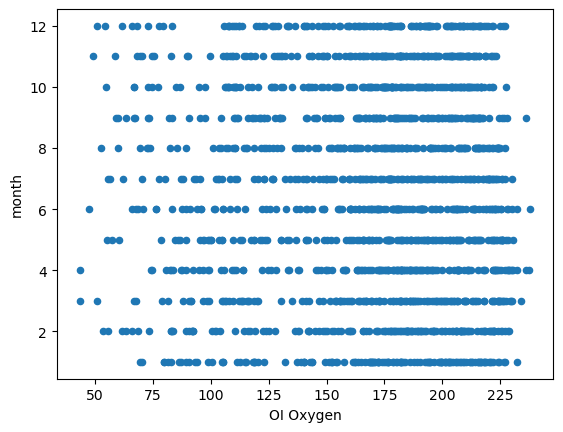

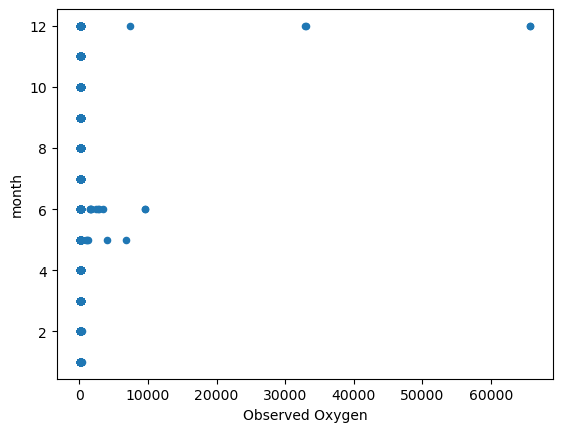

In [196]:
df_oxygen[['month', 'dissolved_oxygen']].plot.scatter(x='dissolved_oxygen',y='month', xlabel='OI Oxygen')
df_test_o[['month', 'dissolved_oxygen']].plot.scatter(x='dissolved_oxygen',y='month', xlabel='Observed Oxygen')

<Axes: xlabel='month'>

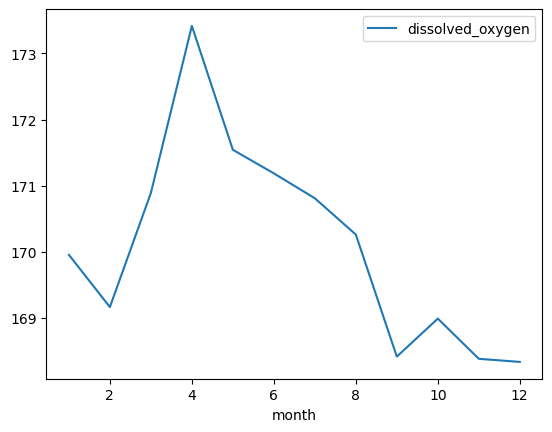

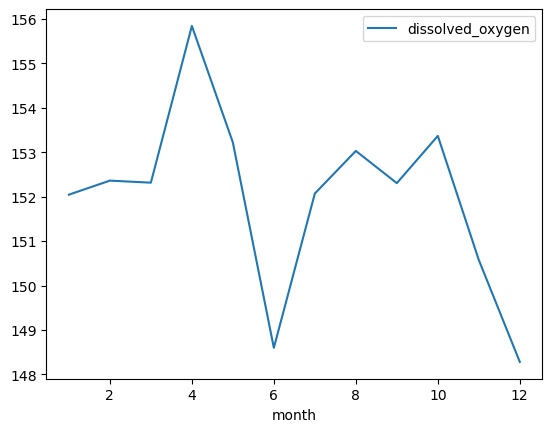

In [194]:
df_oxygen[['month', 'dissolved_oxygen']].groupby('month').mean().plot.line()
df_test_o[['month', 'dissolved_oxygen']][df_test_o['dissolved_oxygen'] < 240].groupby('month').mean().plot.line()


In [160]:
df_test_o.sort_values(['lat','month'])

,lat,lon,month,dissolved_oxygen
0,-15.0,-100.0,1,113.316178
12,-15.0,-95.0,1,91.667890
24,-15.0,-90.0,1,97.858185
36,-15.0,-85.0,1,66.012163
48,-15.0,-80.0,1,77.986325
...,...,...,...,...
1417,30.0,-45.0,12,209.538133
1443,30.0,-30.0,12,210.032890
1455,30.0,-25.0,12,212.387553
1467,30.0,-20.0,12,219.335667


# Test 1

In [26]:
df_list1 = [df_monthly_cho, df_depth_expanded, df_sst,df_oxygen,df_phosphate, df_silicate, df_nitrate, df_salinity,df_temp] 

In [28]:
merged_df1 = reduce(lambda left, right: pd.merge(left, right, on=['lat', 'lon', 'month'],how='left'), df_list1)

In [29]:
merged_df1['dissolved_oxygen'].isna().sum()

14200

Rmse: 0.77
Feature Importances:
chlor_a: 0.004434121306985617
Elevation: 0.031150737777352333
sst: 0.010776953771710396
phosphate: 0.22673191130161285
silicate: 0.032880619168281555
nitrate: 0.10997416824102402
salinity: 0.5286473035812378
Temp: 0.055404193699359894


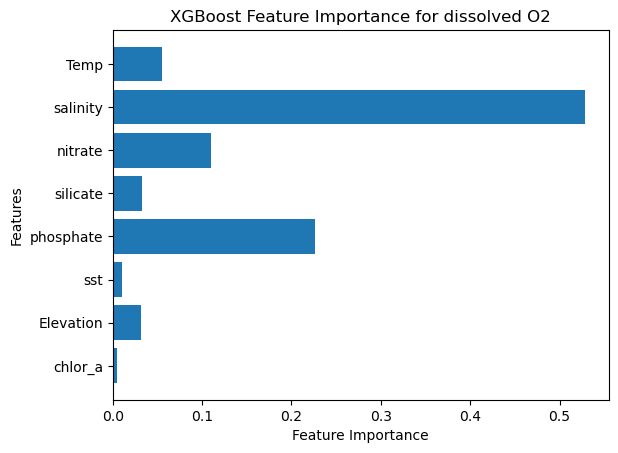

In [30]:
def split_data(df_main):
  # Split features and target
  df = df_main.copy()
  df.set_index(['lon', 'lat', 'month'], inplace=True)
  df = df.dropna(subset='dissolved_oxygen')


  X = df.drop('dissolved_oxygen', axis=1)
  y = df['dissolved_oxygen']

  # Split into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = split_data(merged_df1)


model = xgb.XGBRegressor(
    max_depth=100,  # Maximum depth of a tree
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of trees
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    gamma=0,  # Minimum loss reduction required to make a further partition
    min_child_weight=1  # Minimum sum of instance weight needed in a child
)

# Train the model
model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = model.predict(X_test)


# Evaluate the model (example using accuracy)
mse = mean_squared_error(y_pred,y_test)

rmse = np.sqrt(mse)


print(f"Rmse: {rmse:.2f}")


# Explore feature importance
feature_importances = model.feature_importances_
print("Feature Importances:")
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

# Visualize feature importance
plt.barh(X_train.columns, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance for dissolved O2")
plt.show()


In [31]:
# Explain the model's predictions using SHAP

# The 'explainer' allows you to connect to your trained model and compute / retrieve its SHAP values, regardless of the underlying model type!

explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer(X_test)


# Create an "Explanation" SHAP object;

# This is simply an 'all - encompassing' data structure in SHAP that contains the SHAP values, base values, input feature data, feature names, and some additional
# information about the model / computations that may be needed by some plotting functions for more advanced visualizations

shap_values_explanation = shap.Explanation(shap_values.values, base_values=shap_values.base_values, data=X_test, feature_names=X_test.columns)

# The shap.initjs() function is used here to initialize JavaScript visualizations for our SHAP plots
shap.initjs()

100%|===================| 6729/6760 [03:18<00:00]        

In [32]:
# Visualize the first prediction's explanation
shap.plots.force(explainer.expected_value, shap_values[0].values, X_test.iloc[0, :])

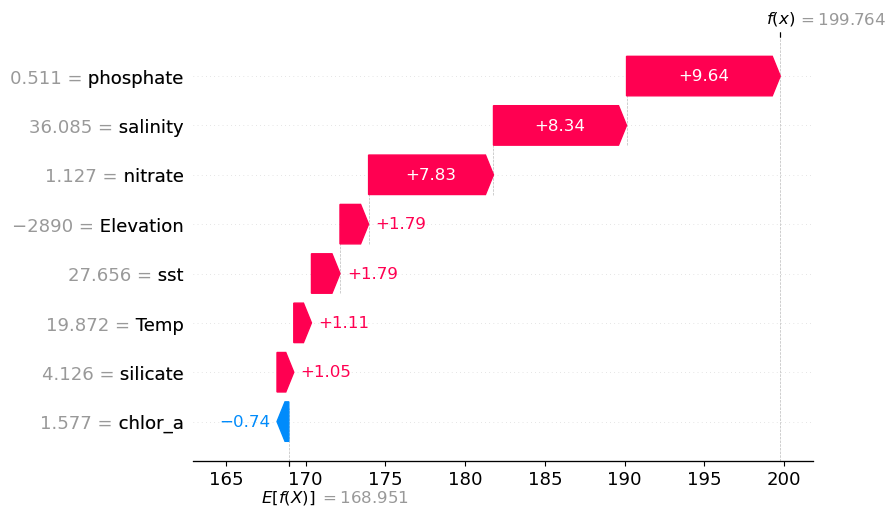

In [33]:
# Waterfall plot for a first instance
shap.waterfall_plot(shap_values_explanation[0])
plt.show()

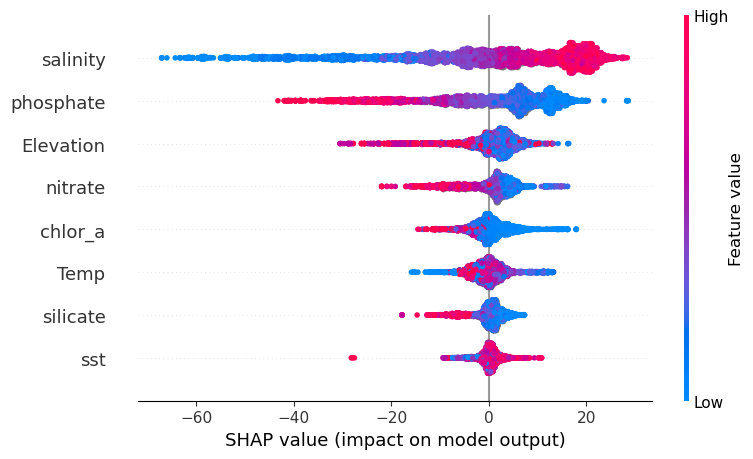

In [35]:
# Summarize the effects of all the features using a beeswarm plot
shap.summary_plot(shap_values, X_test)